In [56]:
library(data.table)
library(dplyr)
library(stringr)
library(stringi)
library(rio)
library(readxl)
library(writexl)
library(readr)
library(readxlsb)
library(data.table)
library(plyr)
library(lubridate)
library(reshape2)
library(anytime)
library(arrow)
library(openxlsx)
library(tidyverse)
library(broom)
library(ggcorrplot)
library(DataExplorer)
library(anytime)
library(olsrr)
library(zoo)

### Reading Data

In [57]:
db_calls <- read_excel("Falcon PR Results v0.1.xlsx",sheet="Calls")
db_sales <- read_excel("Falcon PR Results v0.1.xlsx",sheet="Sales")
setDT(db_calls)
setDT(db_sales)

patient_count <- read_excel("Cancer Patients.xlsx")
setDT(patient_count)

New names:
• `` -> `...44`


### Data Processing

In [58]:
#Sales Data Gathering
db_sales_1 <- gather(db_sales, key = "Date", value = "Sales", `44785`:`45051`)
db_sales_1$Week1 <- as.Date(as.numeric(db_sales_1$Date), origin = "1899-12-30")
head(db_sales_1,2)
summary(db_sales_1)

,NPI,Segment,Date,Sales,Week1
,<dbl>,<chr>,<chr>,<dbl>,<date>
1,3854648575,Low,44785,0,2022-08-12
2,6597938497,High,44785,0,2022-08-12


      NPI              Segment              Date               Sales         
 Min.   :1.001e+09   Length:552084      Length:552084      Min.   : 0.00000  
 1st Qu.:3.243e+09   Class :character   Class :character   1st Qu.: 0.00000  
 Median :5.475e+09   Mode  :character   Mode  :character   Median : 0.00000  
 Mean   :5.479e+09                                         Mean   : 0.08169  
 3rd Qu.:7.726e+09                                         3rd Qu.: 0.00000  
 Max.   :9.999e+09                                         Max.   :26.07100  
     Week1           
 Min.   :2022-08-12  
 1st Qu.:2022-10-14  
 Median :2022-12-23  
 Mean   :2022-12-23  
 3rd Qu.:2023-03-03  
 Max.   :2023-05-05  

In [59]:
#Calls Data Gathering
db_calls_1 <- gather(db_calls, key = "Date", value = "Calls", `44771`:`45051`)
db_calls_1$Week1 <- as.Date(as.numeric(db_calls_1$Date), origin = "1899-12-30")
head(db_calls_1,2)
summary(db_calls_1)

,NPI,Segment,...44,Date,Calls,Week1
,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<date>
1,3854648575,Low,3,44771,0,2022-07-29
2,6597938497,High,7,44771,0,2022-07-29


      NPI              Segment              ...44            Date          
 Min.   :1.001e+09   Length:580396      Min.   : 0.000   Length:580396     
 1st Qu.:3.243e+09   Class :character   1st Qu.: 2.000   Class :character  
 Median :5.475e+09   Mode  :character   Median : 4.000   Mode  :character  
 Mean   :5.479e+09                      Mean   : 5.785                     
 3rd Qu.:7.726e+09                      3rd Qu.: 8.000                     
 Max.   :9.999e+09                      Max.   :69.000                     
     Calls            Week1           
 Min.   :0.0000   Min.   :2022-07-29  
 1st Qu.:0.0000   1st Qu.:2022-10-07  
 Median :0.0000   Median :2022-12-16  
 Mean   :0.1411   Mean   :2022-12-16  
 3rd Qu.:0.0000   3rd Qu.:2023-02-24  
 Max.   :6.0000   Max.   :2023-05-05  

In [60]:
patient_count$YRMO <- as.numeric(format(patient_count$Month, "%Y%m"))
head(patient_count,2)

Month,Patients,YRMO
<dttm>,<dbl>,<dbl>
2022-01-01,164200,202201
2022-02-01,159800,202202


In [61]:
mdb_a <- merge(x=db_sales_1,y=db_calls_1,by=c("NPI","Segment","Week1","Date"),all=T)
mdb_a$Date <- NULL
mdb_a$YRMO <- as.numeric(format(mdb_a$Week, "%Y%m"))
mdb_a$Quarter <- as.yearqtr(mdb_a$Week)
mdb_a[is.na(mdb_a)] <- 0
mdb <- setDT(copy(mdb_a))

In [63]:
colSums(db_sales_1[, sapply(db_sales_1, is.numeric)])
colSums(db_calls_1[, sapply(db_calls_1, is.numeric)])
colSums(mdb_a[, sapply(mdb_a, is.numeric)])

NPI        Sales 
3.025120e+15 4.510082e+04

NPI        ...44        Calls 
3.180254e+15 3.357613e+06 8.189300e+04

NPI        Sales        ...44        Calls         YRMO 
3.180254e+15 4.510082e+04 3.357613e+06 8.189300e+04 1.173855e+11

In [64]:
mdb[,lapply(.SD, sum, na.rm=TRUE),by="Segment",.SDcols = c("Sales","Calls")]

Segment,Sales,Calls
<chr>,<dbl>,<dbl>
-,2481.979,11717
High,17113.592,18623
Medium,16620.868,32656
Low,8884.376,18897


In [65]:
mdb_week <- mdb[,lapply(.SD, sum, na.rm=TRUE),by=c("NPI","Segment","Week1"),.SDcols = c("Sales","Calls")]
mdb_week <- complete(mdb_week,NPI,Week1)
setDT(mdb_week)
mdb_week[is.na(mdb_week)] <- 0
mdb_week <- mdb_week %>% arrange(NPI, Week1)

In [66]:
mdb_month <- mdb[,lapply(.SD, sum, na.rm=TRUE),by=c("NPI","Segment","YRMO"),.SDcols = c("Sales","Calls")]
mdb_month <- merge(x=mdb_month,y=patient_count[,c('YRMO','Patients')],by=c("YRMO"),all.x=T)
mdb_month <- complete(mdb_month,NPI,YRMO)
setDT(mdb_month)
mdb_month[is.na(mdb_month)] <- 0
mdb_month <- mdb_month %>% arrange(NPI, YRMO)
setDT(mdb_month)

In [67]:
mdb_quarter <- mdb[,lapply(.SD, sum, na.rm=TRUE),by=c("NPI","Segment","Quarter"),.SDcols = c("Sales","Calls")]
mdb_quarter <- complete(mdb_quarter,NPI,Quarter)
setDT(mdb_quarter)
mdb_quarter[is.na(mdb_quarter)] <- 0
mdb_quarter <- mdb_quarter %>% arrange(NPI, Quarter)
setDT(mdb_quarter)

In [68]:
mdb_month$Calls_log_k1 <- log(1 + 1*mdb_month$Calls)
mdb_month$Calls_log_k0_5 <- log(1 + 0.5*mdb_month$Calls)
mdb_month$Calls_log_k0_7 <- log(1 + 0.7*mdb_month$Calls)

In [69]:
mdb_month[,lapply(.SD, sum, na.rm=TRUE),by=c("YRMO"),.SDcols = c("Sales","Calls")]

YRMO,Sales,Calls
<dbl>,<dbl>,<dbl>
202207,0.000,44
202208,325.045,4573
202209,1443.802,6086
202210,2404.225,8839
202211,3105.588,8111
202212,5440.802,9598
202301,5135.263,8369
202302,6431.924,10231
202303,9891.251,13423


In [70]:
list2 <- list()
for(i in 'Calls'){
  list2[[i]] <- mdb_month[,by=c("Segment"),.(reach = uniqueN(`NPI`[get(i) != 0]), 
                                                                               act = sum(get(i)))]
}

display_reach_freq <- bind_rows(list2, .id = "column_label")
display_reach_freq

column_label,Segment,reach,act
<chr>,<chr>,<int>,<dbl>
Calls,-,3531,11717
Calls,High,1838,18623
Calls,Medium,4824,32656
Calls,Low,3431,18897


In [71]:
#keeping columns only for MDB

mdb_month <- mdb_month[YRMO > 202208 & YRMO < 202305]

In [72]:
#Carryover Creation

In [73]:
mdb_month$Carryover <- lag(mdb_month$Sales,1)
mdb_month[is.na(mdb_month)] <- 0

In [74]:
# Correaltion Matrix

In [75]:
round(cor(mdb_month[,-c("NPI","Segment","YRMO")])*100,1)

,Sales,Calls,Patients,Calls_log_k1,Calls_log_k0_5,Calls_log_k0_7,Carryover
Sales,100.0,29.6,0.4,26.7,27.6,27.2,65.7
Calls,29.6,100.0,-2.4,96.8,98.3,97.6,20.8
Patients,0.4,-2.4,100.0,-2.5,-2.5,-2.5,9.5
Calls_log_k1,26.7,96.8,-2.5,100.0,99.7,99.9,18.8
Calls_log_k0_5,27.6,98.3,-2.5,99.7,100.0,99.9,19.4
Calls_log_k0_7,27.2,97.6,-2.5,99.9,99.9,100.0,19.1
Carryover,65.7,20.8,9.5,18.8,19.4,19.1,100.0


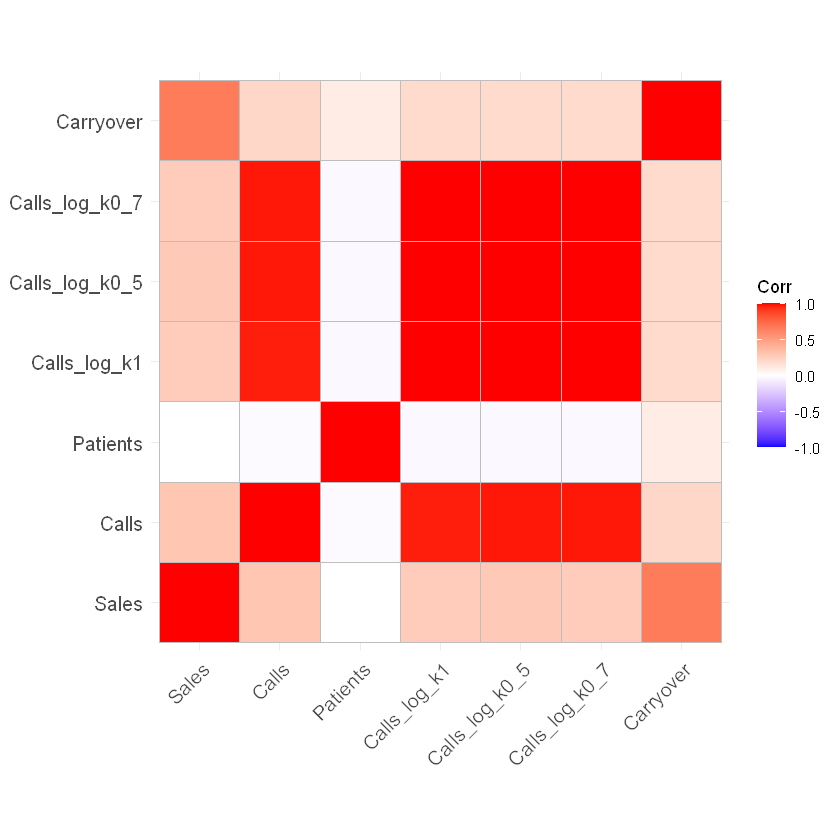

In [76]:
ggcorrplot(cor(mdb_month[,-c("NPI","Segment","YRMO")]))

In [77]:
model <- mdb_month[Segment != '-']

In [78]:
list2 <- list()
for(i in 'Calls'){
  list2[[i]] <- model[,by=c("Segment","YRMO"),.(reach = uniqueN(`NPI`[get(i) != 0]), 
                                                                               act = sum(get(i)))]
}

display_reach_freq <- bind_rows(list2, .id = "column_label")
display_reach_freq

column_label,Segment,YRMO,reach,act
<chr>,<chr>,<dbl>,<int>,<dbl>
Calls,High,202209,999,1609
Calls,High,202210,1235,2130
Calls,High,202211,1108,1824
Calls,High,202212,1199,2207
Calls,High,202301,1143,1867
Calls,High,202302,1214,2191
Calls,High,202303,1371,2872
Calls,High,202304,1201,2230
Calls,Medium,202209,1836,2491


In [79]:
# write.csv(model,'model.csv',row.names=FALSE)

In [80]:
model <- merge(x=model,y=display_reach_freq,by=c('Segment','YRMO'),all.x=T)

In [81]:
# Numerator columns
numerator_cols <- grep("Calls", names(model), value = TRUE)

# Denominator columns
denominator_cols <- c("reach","Patients")

# Divide numerator columns by denominator columns and rename new columns
for (num_col in numerator_cols) {
  for (denom_col in denominator_cols) {
    new_col_name <- paste0(num_col, "_norm_", denom_col)
    model[[new_col_name]] <- model[[num_col]] / model[[denom_col]]
  }
}


In [82]:
head(model)

Segment,YRMO,NPI,Sales,Calls,Patients,Calls_log_k1,Calls_log_k0_5,Calls_log_k0_7,Carryover,⋯,reach,act,Calls_norm_reach,Calls_norm_Patients,Calls_log_k1_norm_reach,Calls_log_k1_norm_Patients,Calls_log_k0_5_norm_reach,Calls_log_k0_5_norm_Patients,Calls_log_k0_7_norm_reach,Calls_log_k0_7_norm_Patients
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
High,202209,1002977991,0.000,0,168600,0.000000,0.0000000,0.0000000,0.000,⋯,999,1609,0.000000000,0.000000e+00,0.000000000,0.000000e+00,0.0000000000,0.000000e+00,0.0000000000,0.000000e+00
High,202209,1005957290,0.000,0,168600,0.000000,0.0000000,0.0000000,5.561,⋯,999,1609,0.000000000,0.000000e+00,0.000000000,0.000000e+00,0.0000000000,0.000000e+00,0.0000000000,0.000000e+00
High,202209,1018552872,0.000,3,168600,1.386294,0.9162907,1.1314021,0.000,⋯,999,1609,0.003003003,1.779359e-05,0.001387682,8.222386e-06,0.0009172079,5.434702e-06,0.0011325346,6.710570e-06
High,202209,1022856683,0.000,0,168600,0.000000,0.0000000,0.0000000,0.858,⋯,999,1609,0.000000000,0.000000e+00,0.000000000,0.000000e+00,0.0000000000,0.000000e+00,0.0000000000,0.000000e+00
High,202209,1025529751,5.327,2,168600,1.098612,0.6931472,0.8754687,0.000,⋯,999,1609,0.002002002,1.186240e-05,0.001099712,6.516087e-06,0.0006938410,4.111193e-06,0.0008763451,5.192579e-06
High,202209,1026175920,0.000,2,168600,1.098612,0.6931472,0.8754687,0.000,⋯,999,1609,0.002002002,1.186240e-05,0.001099712,6.516087e-06,0.0006938410,4.111193e-06,0.0008763451,5.192579e-06


In [83]:
names(model)

[1] "Segment"                      "YRMO"                        
 [3] "NPI"                          "Sales"                       
 [5] "Calls"                        "Patients"                    
 [7] "Calls_log_k1"                 "Calls_log_k0_5"              
 [9] "Calls_log_k0_7"               "Carryover"                   
[11] "column_label"                 "reach"                       
[13] "act"                          "Calls_norm_reach"            
[15] "Calls_norm_Patients"          "Calls_log_k1_norm_reach"     
[17] "Calls_log_k1_norm_Patients"   "Calls_log_k0_5_norm_reach"   
[19] "Calls_log_k0_5_norm_Patients" "Calls_log_k0_7_norm_reach"   
[21] "Calls_log_k0_7_norm_Patients"

$x
[1] "Calls"

attr(,"class")
[1] "labels"

$y
[1] "Sales"

attr(,"class")
[1] "labels"

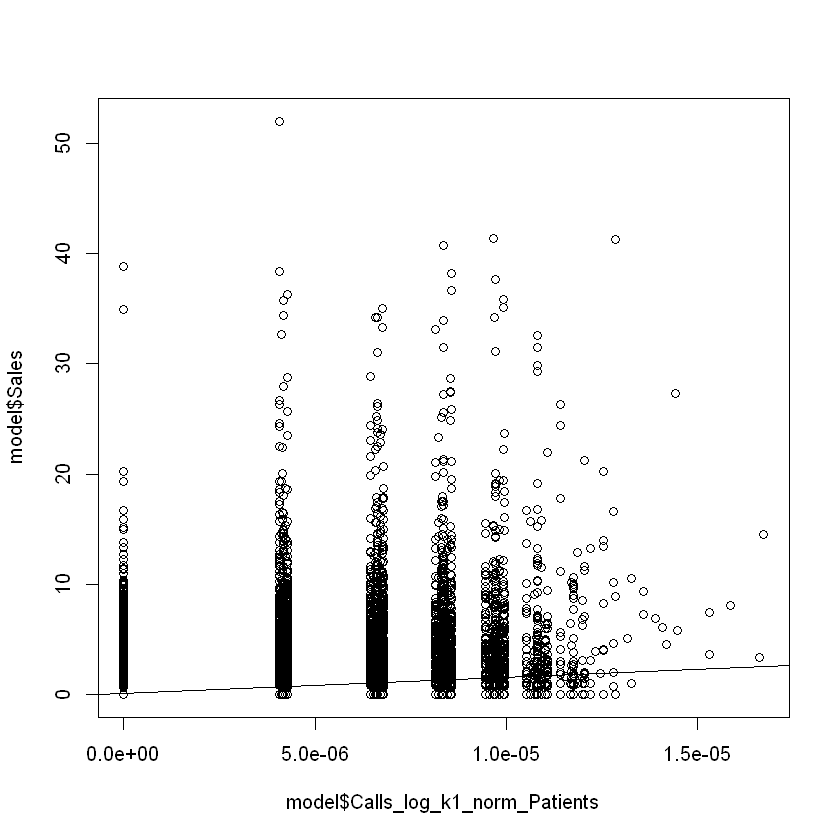

In [84]:
plot(model$Calls_log_k1_norm_Patients,model$Sales)
xlab("Calls")
ylab("Sales")
abline(lm(model$Sales ~ model$Calls_log_k1_norm_Patients))


### Modeling Results

In [85]:
m1 <- lm(Sales ~ Carryover + Calls_log_k1:Segment, data=model)
summary(m1)


Call:
lm(formula = Sales ~ Carryover + Calls_log_k1:Segment, data = model)

Residuals:
    Min      1Q  Median      3Q     Max 
-34.384  -0.236   0.026   0.026  36.402 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                -0.025744   0.005585  -4.609 4.04e-06 ***
Carryover                   0.662022   0.002645 250.248  < 2e-16 ***
Calls_log_k1:SegmentHigh    0.772847   0.013306  58.084  < 2e-16 ***
Calls_log_k1:SegmentLow     0.308819   0.013377  23.085  < 2e-16 ***
Calls_log_k1:SegmentMedium  0.378324   0.010802  35.023  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.175 on 82483 degrees of freedom
Multiple R-squared:  0.4891,	Adjusted R-squared:  0.4891 
F-statistic: 1.974e+04 on 4 and 82483 DF,  p-value: < 2.2e-16


Warning message in int_abline(a = a, b = b, h = h, v = v, untf = untf, ...):
""wd" is not a graphical parameter"


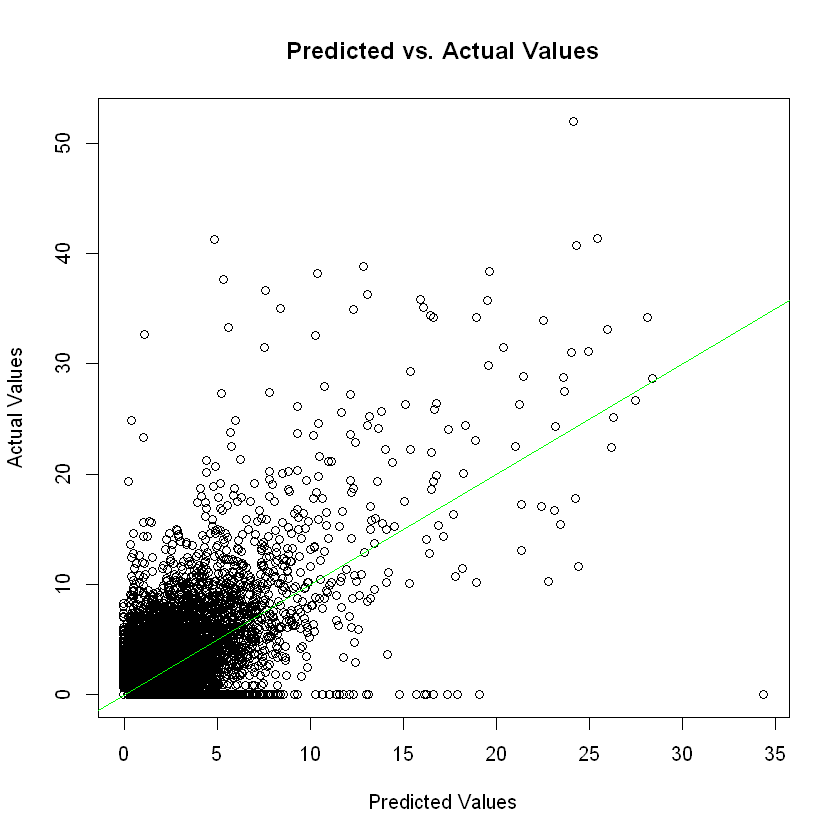

In [86]:
plot(x=predict(m1), y= model$Sales,
     xlab='Predicted Values',
     ylab='Actual Values',
     main='Predicted vs. Actual Values')
abline(a=0, b=1, col = "green",wd = 4)

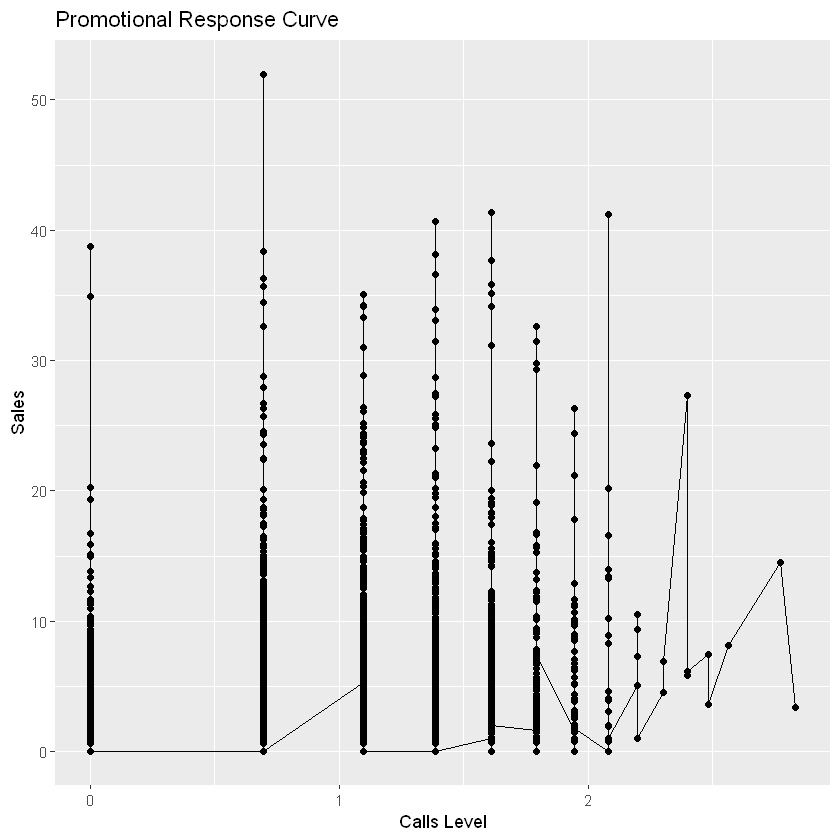

In [87]:
ggplot(model, aes(x = Calls_log_k1, y = Sales)) +
  geom_line() +
  geom_point() +
  xlab("Calls Level") +
  ylab("Sales") +
  ggtitle("Promotional Response Curve")

In [88]:
tidy(m1)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-0.0257441,0.005585143,-4.609389,4.044576e-06
Carryover,0.6620219,0.002645467,250.247676,0.000000e+00
Calls_log_k1:SegmentHigh,0.7728471,0.013305775,58.083585,0.000000e+00
Calls_log_k1:SegmentLow,0.3088187,0.013377312,23.085260,1.539333e-117
Calls_log_k1:SegmentMedium,0.3783242,0.010802234,35.022773,9.328660e-267


[[1]]
NULL

[[2]]
NULL


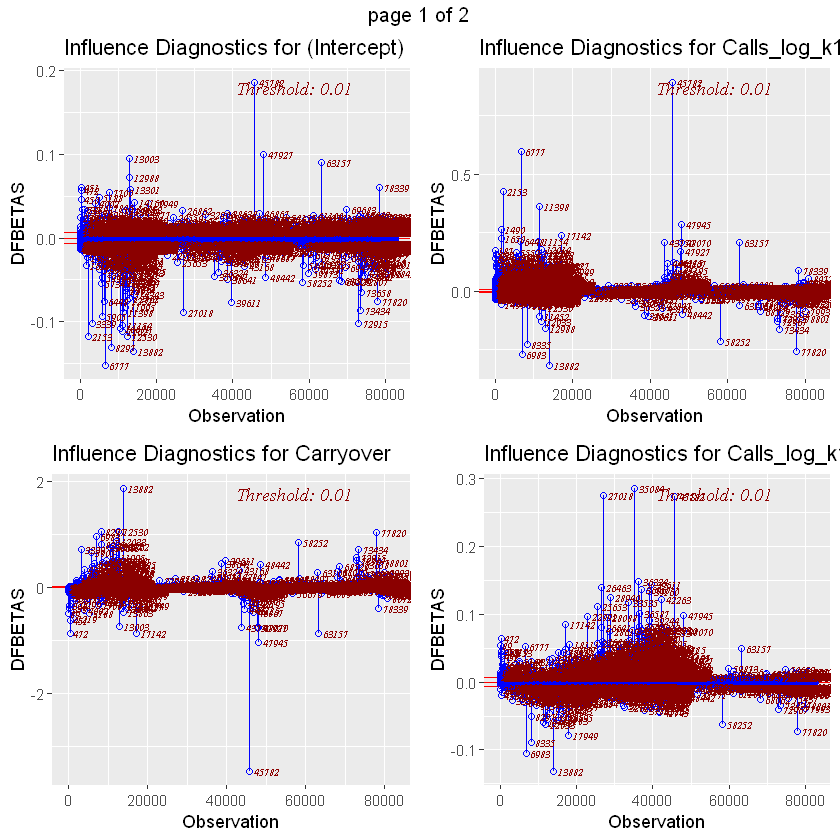

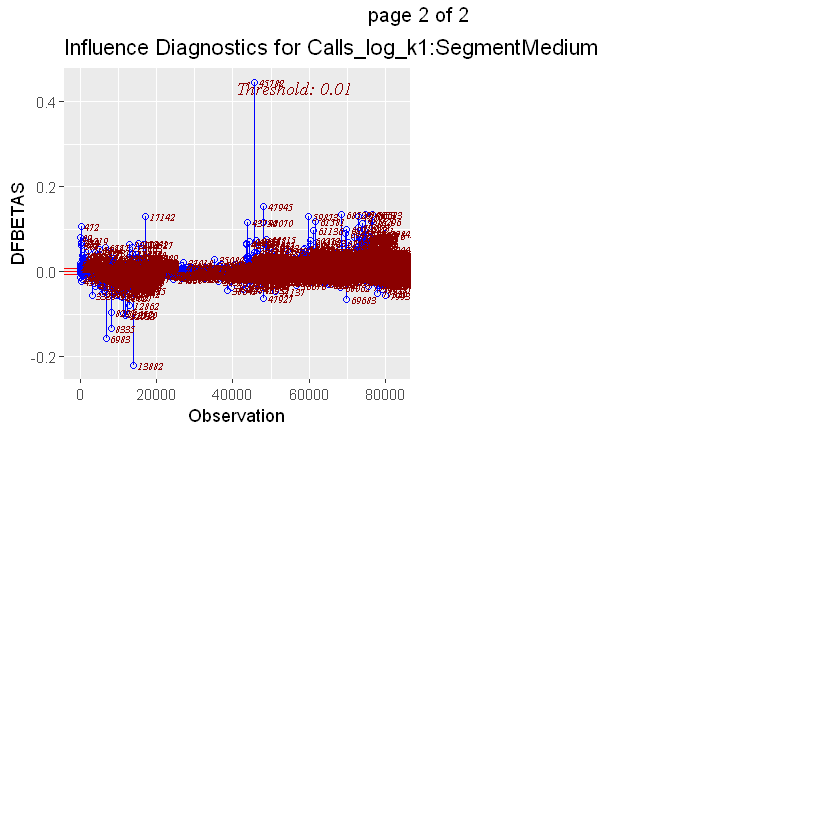

In [89]:
olsrr::ols_plot_dfbetas(m1)